## POS tagging using modified Viterbi


Let's learn how to do POS tagging by Viterbi Heuristic using tagged Treebank corpus. Before going through the code,  pseudo-code for the same. 

1. Create Tagged Treebank corpus  (Sample data to training and test data set)
   - Basic text and structure exploration
2. Creating HMM model on the tagged data set.
   - Calculating Emission Probabaility: P(observation|state)
   - Calculating Transition Probability: P(state2|state1)
3. Developing algorithm for Viterbi Heuristic
4. Checking accuracy on the test data set
5. Create 2 methods to modify viterbi to resolve the problem of unknown words 
6. List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

### Data Preparation

In [7]:
#Importing libraries
import nltk, re,  pprint
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random,time
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize


In [8]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [9]:
#print first few sentences 
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [10]:
# splitting into train and test set
random.seed(1234)
train_set , test_set = train_test_split(nltk_data , test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:5])

3718
196
[[('On', 'ADP'), ('the', 'DET'), ('back', 'NOUN'), (',', '.'), ('the', 'DET'), ('shirts', 'NOUN'), ('read', 'VERB'), (',', '.'), ('``', '.'), ('We', 'PRON'), ('have', 'VERB'), ('all', 'DET'), ('the', 'DET'), ('answers', 'NOUN'), ('.', '.'), ("''", '.')], [('``', '.'), ('A', 'DET'), ('whole', 'ADJ'), ('day', 'NOUN'), ('goes', 'VERB'), ('by', 'ADV'), ('and', 'CONJ'), ('no', 'DET'), ('one', 'NOUN'), ('even', 'ADV'), ('knows', 'VERB'), ('0', 'X'), ('they', 'PRON'), ("'re", 'VERB'), ('alive', 'ADJ'), ('.', '.')], [('The', 'DET'), ('new', 'ADJ'), (',', '.'), ('seven-year', 'ADJ'), ('funds', 'NOUN'), ('--', '.'), ('one', 'NUM'), ('offering', 'VERB'), ('a', 'DET'), ('fixed-rate', 'ADJ'), ('return', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('other', 'ADJ'), ('with', 'ADP'), ('a', 'DET'), ('floating-rate', 'ADJ'), ('return', 'NOUN'), ('linked', 'VERB'), ('*', 'X'), ('to', 'PRT'), ('the', 'DET'), ('London', 'NOUN'), ('interbank', 'NOUN'), ('offered', 'VERB'), ('rate', 'NOUN'), ('--', '.

In [11]:
# finding the list of train tagged words ( as train_set contains sentences )
train_tagged_words = [ tup for sent in train_set for tup in sent ]
len(train_tagged_words)

95559

In [12]:
#find the tokens
tokens = [word for word , tag in train_tagged_words]
tokens[:10]

['On', 'the', 'back', ',', 'the', 'shirts', 'read', ',', '``', 'We']

In [13]:
#Vocabulary
V = set(tokens)
print(len(V))

12089


`There are 12086 unique words in this data set`

In [14]:
# find the unique tags 
T = list(set([tag for word , tag in train_tagged_words]))
print(len(T))
print(T)

12
['ADJ', 'ADV', '.', 'ADP', 'PRT', 'CONJ', 'DET', 'VERB', 'X', 'PRON', 'NOUN', 'NUM']


` As we can see there are only 12 unique tags present in nltk universal tagged dataset`

### Build the vanilla Viterbi based POS tagger
We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 

### Emission Probability

In [15]:
#Computing p(w/t) and storing in it T X V matrix
t= len(T)
v = len(V)
w_given_t = np.zeros((t,v))

In [16]:
# compute word given tag emission probability
def word_given_tag(word , tag , train_bag = train_tagged_words):
    tag_list = [pair for pair in train_tagged_words if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word] 
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag) 
       
      
       

In [17]:
print(word_given_tag('The' , 'DET'))
print(word_given_tag('People','NOUN'))

(685, 8272)
(5, 27393)


### Transition Probability

In [18]:
# compute tag given tag : i.e t2 given t1 (Transition proabability)
def t2_given_t1(t2, t1, train_bag= train_tagged_words):
    tags = [pair[1] for pair in train_bag ]
    count_t1 = len([t for t in tags if t==t1 ])
    count_t2_t1=0
    for i in range (len(tags)-1):
        if tags[i]==t1 and tags[i+1]==t2:
            count_t2_t1+=1
    return (count_t2_t1 , count_t1)           
    

In [19]:
print(t2_given_t1('DET' , 'NOUN'))
print(t2_given_t1('VERB','NOUN'))
print(t2_given_t1('NOUN' ,'DET'))


(366, 27393)
(4001, 27393)
(5268, 8272)


In [20]:
# create t X t matrix to store the transition probability of all the tags
tags_matrix = np.zeros((len(T) , len(T)), dtype= 'float32')
for i , t1 in enumerate(T):
    for j ,t2 in enumerate(T):
        tags_matrix[i,j] =t2_given_t1(t2,t1)[0]/t2_given_t1(t2,t1)[1]
tags_matrix

array([[6.60098493e-02, 4.26929398e-03, 6.42036125e-02, 7.68472925e-02,
        1.10016419e-02, 1.67487692e-02, 4.92610829e-03, 1.19868638e-02,
        2.06896551e-02, 6.56814431e-04, 7.01149404e-01, 2.15106737e-02],
       [1.29353240e-01, 8.05970132e-02, 1.34660035e-01, 1.19402982e-01,
        1.39303487e-02, 7.29684904e-03, 6.66666701e-02, 3.46268654e-01,
        2.32172478e-02, 1.55887231e-02, 3.15091200e-02, 3.15091200e-02],
       [4.42708321e-02, 5.19037358e-02, 9.41091925e-02, 9.02478471e-02,
        2.33477005e-03, 5.85488491e-02, 1.74299568e-01, 8.98886472e-02,
        2.72090510e-02, 6.53735623e-02, 2.20815375e-01, 8.09087679e-02],
       [1.07287884e-01, 1.35712763e-02, 4.02863845e-02, 1.67770889e-02,
        1.49604620e-03, 8.54883518e-04, 3.23252827e-01, 7.90767279e-03,
        3.47296447e-02, 6.92455620e-02, 3.21222484e-01, 6.33682385e-02],
       [8.46456662e-02, 1.01706041e-02, 4.39632535e-02, 2.06692908e-02,
        1.96850393e-03, 2.29658792e-03, 1.00721784e-01, 4.00

In [21]:
# lets convert the matrix to dataframe 
tags_df = pd.DataFrame(tags_matrix , columns = T , index = T)
tags_df.head(10)

,ADJ,ADV,.,ADP,PRT,CONJ,DET,VERB,X,PRON,NOUN,NUM
ADJ,0.066010,0.004269,0.064204,0.076847,0.011002,0.016749,0.004926,0.011987,0.020690,0.000657,0.701149,0.021511
ADV,0.129353,0.080597,0.134660,0.119403,0.013930,0.007297,0.066667,0.346269,0.023217,0.015589,0.031509,0.031509
.,0.044271,0.051904,0.094109,0.090248,0.002335,0.058549,0.174300,0.089889,0.027209,0.065374,0.220815,0.080909
ADP,0.107288,0.013571,0.040286,0.016777,0.001496,0.000855,0.323253,0.007908,0.034730,0.069246,0.321222,0.063368
PRT,0.084646,0.010171,0.043963,0.020669,0.001969,0.002297,0.100722,0.400262,0.013780,0.017717,0.246719,0.057087
CONJ,0.119424,0.055297,0.034387,0.052509,0.005112,0.000465,0.118959,0.153810,0.008364,0.059015,0.349442,0.043216
DET,0.205996,0.013056,0.016925,0.009309,0.000242,0.000363,0.005077,0.040619,0.045334,0.003627,0.636847,0.022606
VERB,0.065681,0.082490,0.034786,0.091051,0.031595,0.004903,0.134708,0.168016,0.217588,0.035642,0.110661,0.022879
X,0.017250,0.025874,0.165309,0.143108,0.183996,0.010062,0.053825,0.205239,0.074429,0.056061,0.061971,0.002875
PRON,0.072336,0.033474,0.039631,0.022316,0.013082,0.005002,0.010004,0.486726,0.093882,0.007311,0.209311,0.006926


In [22]:
# As we can see below that mostly sentences start with Noun as probability is high
tags_df['.']

ADJ     0.064204
ADV     0.134660
.       0.094109
ADP     0.040286
PRT     0.043963
CONJ    0.034387
DET     0.016925
VERB    0.034786
X       0.165309
PRON    0.039631
NOUN    0.240645
NUM     0.114919
Name: ., dtype: float32

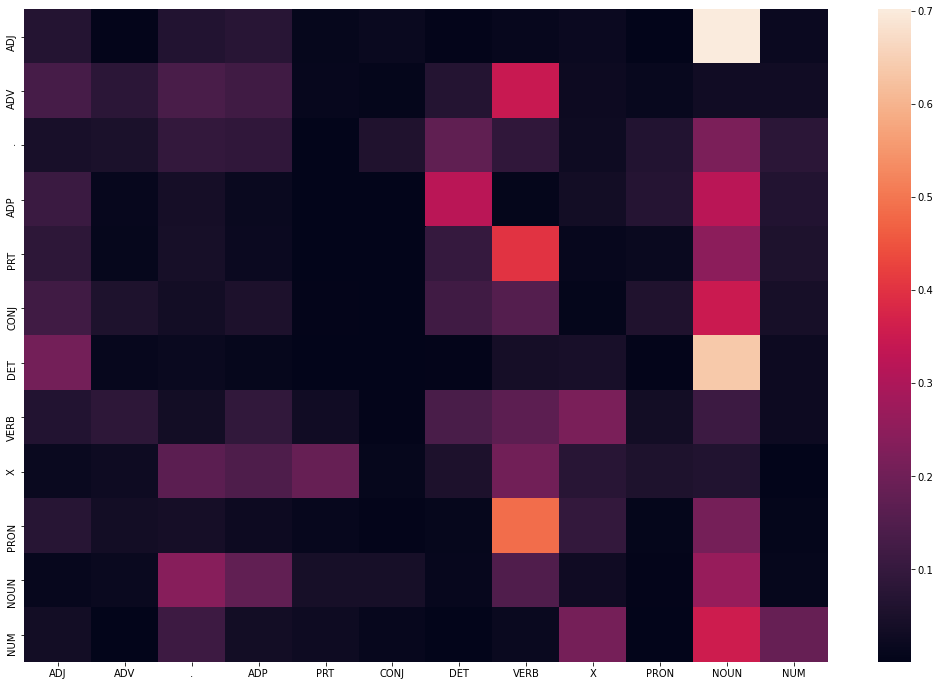

In [23]:
# Now we can plot all the tags in heatmap to see the most correlated tags
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=[18,12])
sns.heatmap(tags_df)
plt.show()

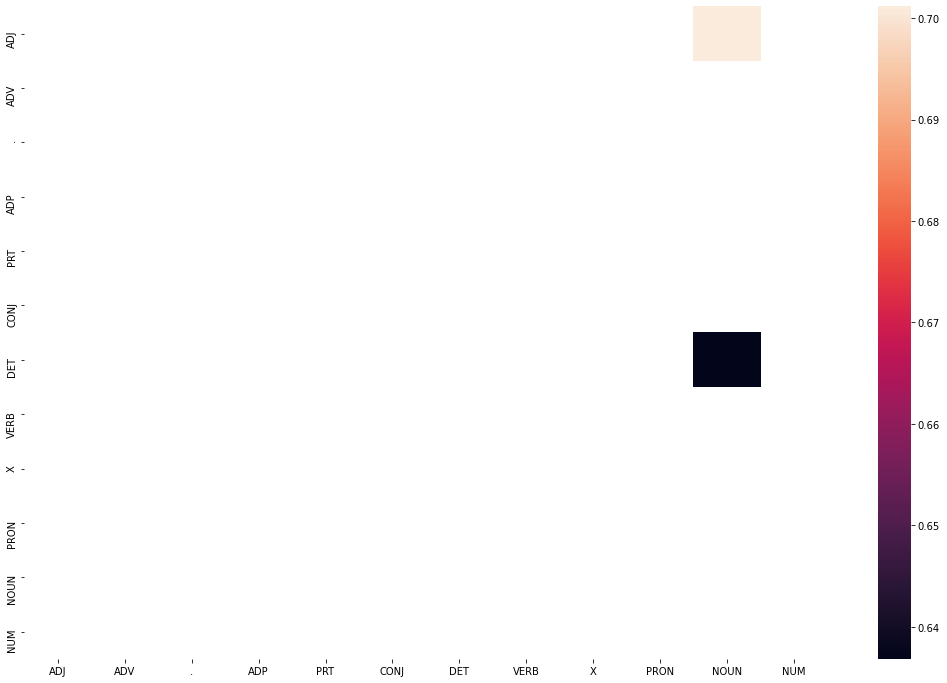

In [24]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [25]:
#Viterbi hueristic
def Viterbi(words, train_bag= train_tagged_words):
    state=[]
    T= list(set(pair[1] for pair in train_bag))
    for key, word in enumerate(words):
        p=[]
        for tag in T:
            if key==0:
                transition_prb = tags_df.loc['.',tag]
            else:
                transition_prb = tags_df.loc[state[-1],tag]
                
            emission_prb = word_given_tag(word , tag)[0]/word_given_tag(word,tag)[1]
            state_prb = transition_prb*emission_prb
            p.append(state_prb)
        maxprob = max(p)
        #getting the state tage for which probabaility is maximum
        state_max= T[p.index(maxprob)]
        state.append(state_max)
    return(list(zip(words,state)))
        

### Evaluate on test set

In [26]:
# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]
# lis of untagged words 
test_untagged_words = [pair[0] for pair in test_run_base]
print(test_run_base[:5])
print(test_untagged_words[:5])

[('Ralston', 'NOUN'), ('attributed', 'VERB'), ('its', 'PRON'), ('fourth-quarter', 'NOUN'), ('slump', 'NOUN')]
['Ralston', 'attributed', 'its', 'fourth-quarter', 'slump']


In [27]:
start = time.time()
tagged_seq_vanilla_viterbi = Viterbi(test_untagged_words)
end = time.time()



In [28]:
time_diff= end-start
print("Time taken in seconds: ", time_diff)
print(tagged_seq_vanilla_viterbi)

Time taken in seconds:  851.9247119426727
[('Ralston', 'NOUN'), ('attributed', 'VERB'), ('its', 'PRON'), ('fourth-quarter', 'NOUN'), ('slump', 'NOUN'), ('partly', 'ADV'), ('to', 'PRT'), ('higher', 'ADJ'), ('costs', 'NOUN'), ('of', 'ADP'), ('ingredients', 'ADJ'), ('in', 'ADP'), ('the', 'DET'), ('pet', 'NOUN'), ('food', 'NOUN'), ('business', 'NOUN'), ('as', 'ADP'), ('well', 'ADV'), ('as', 'ADP'), ('competitive', 'ADJ'), ('pressures', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('required', 'VERB'), ('higher', 'ADJ'), ('advertising', 'NOUN'), ('spending', 'NOUN'), ('.', '.'), ('Trinity', 'NOUN'), ('Industries', 'NOUN'), ('Inc.', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('reached', 'VERB'), ('a', 'DET'), ('preliminary', 'ADJ'), ('agreement', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('sell', 'VERB'), ('500', 'NUM'), ('railcar', 'ADJ'), ('platforms', 'ADJ'), ('to', 'PRT'), ('Trailer', 'ADJ'), ('Train', 'ADJ'), ('Co.', 'NOUN'), ('of', 'ADP'), ('Chicago', 'NOUN'), ('.', '.'

In [29]:
# Vanilla Viterbi accuracy
check = [i for i, j in zip(tagged_seq_vanilla_viterbi, test_run_base) if i == j] 
Vanilla_Viterbi_accuracy = len(check)/len(tagged_seq_vanilla_viterbi)
Vanilla_Viterbi_accuracy

0.9167480945866718

In [30]:
#Incorrect tagged cases 
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_vanilla_viterbi, test_run_base)) if j[0]!=j[1]]
print( "Incorrect tagged words length :-", len(incorrect_tagged_cases))
incorrect_tagged_cases


Incorrect tagged words length :- 426


[[('of', 'ADP'), (('ingredients', 'ADJ'), ('ingredients', 'NOUN'))],
 [('business', 'NOUN'), (('as', 'ADP'), ('as', 'ADV'))],
 [('500', 'NUM'), (('railcar', 'ADJ'), ('railcar', 'NOUN'))],
 [('railcar', 'NOUN'), (('platforms', 'ADJ'), ('platforms', 'NOUN'))],
 [('to', 'PRT'), (('Trailer', 'ADJ'), ('Trailer', 'NOUN'))],
 [('Trailer', 'NOUN'), (('Train', 'ADJ'), ('Train', 'NOUN'))],
 [('For', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('to', 'PRT'), (('broaden', 'ADJ'), ('broaden', 'VERB'))],
 [("'s", 'PRT'), (('implementation', 'ADJ'), ('implementation', 'NOUN'))],
 [('ringer', 'NOUN'), (('out', 'PRT'), ('out', 'ADP'))],
 [(',', '.'), (('controlled', 'ADJ'), ('controlled', 'VERB'))],
 [('already', 'ADV'), (('own', 'ADJ'), ('own', 'VERB'))],
 [('system', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [(':', '.'), (('MERRILL', 'ADJ'), ('MERRILL', 'NOUN'))],
 [('MERRILL', 'NOUN'), (('LYNCH', 'ADJ'), ('LYNCH', 'NOUN'))],
 [('LYNCH', 'NOUN'), (('READY', 'ADJ'), ('READY', 'NOUN'))

In [33]:
print( "Total train tagged words length :-", len(train_tagged_words))
print( "Total test words length :-", len(test_run_base))
print( "correct test tagged words length :-", len(check))
print( "Incorrect test tagged words length :-", len(incorrect_tagged_cases))

Total train tagged words length :- 95559
Total test words length :- 5117
correct test tagged words length :- 4691
Incorrect test tagged words length :- 426


### Solve the problem of unknown words

`Before solving the problem of unknown words lets find out the unknown words. Unknown words are those which are present in test set but not in train set. `



In [34]:
# v is the unique words in train set 
unknownwords = set(test_untagged_words)-V
print(len(unknownwords))
unknownwords

319


{'*-104',
 '*-107',
 '*-121',
 '*-140',
 '*-150',
 '*-151',
 '*-162',
 '*-165',
 '*-93',
 '*T*-116',
 '*T*-130',
 '*T*-131',
 '*T*-151',
 '*T*-156',
 '*T*-160',
 '*T*-173',
 '*T*-179',
 '*T*-199',
 '*T*-240',
 '*T*-245',
 '*T*-87',
 '1,050,000',
 '1.49',
 '102',
 '12\\/32',
 '14-hour',
 '19.94',
 '1903',
 '1967',
 '2-3',
 '27-year',
 '3.23',
 '35500.64',
 '361.8',
 '37-a-share',
 '387.8',
 '40,000',
 '422.5',
 '436.01',
 '467',
 '5.63',
 '6.4',
 '6.44',
 '63.79',
 '70-a-share',
 '8.64',
 '93',
 'ASSETS',
 'Airways',
 'Alysia',
 'Aptitude',
 'Articles',
 'Bears',
 'Bermuda',
 'Bund',
 'Chinchon',
 'Clarence',
 'Concurrent',
 'Confederation',
 'Consider',
 'Crash',
 'Criticism',
 'DIAPER',
 'Deane',
 'Desai',
 'Different',
 'Everybody',
 'FUNDS',
 'Feniger',
 'Gottlieb',
 'Greenwich',
 'Haden',
 'Hopwood',
 'I.',
 'INGERSOLL-RAND',
 'INTER-TEL',
 'Ideas',
 'Indexing',
 'Intermec',
 'Items',
 'Jaffray',
 'Jenkins',
 'Junk',
 'Keith',
 'Knowing',
 'Kuala',
 'LYNCH',
 'Langner',
 'Legal',
 

### Method 1
Normal Vanilla viterbi algorithm gave 93% of accuracy , 7 % loss was due to unknown words and due to fact that when algorithm encountered unknown word then it assigned an incorrect tag arbitrarily ( first tag). This is because for unknown words are
the emission probability for candidate tags will be zero and hence algorithm choses first tag arbitrarily.
 
Now lets see how we can reduce this loss 

If a word isnt present in training set then its emission probability will be zero and hence state prob. will inturn be zero.Thus in cases we can omit the emission probabaility for unknown words and keep only transition probability.

- Logic will be 
    
 If unknown word then 

    state_prob = Transition_prob
    
    else:

    state_prob = Transition_prob * emission_prob

In [35]:
# training Set vocabulary
print(len(V))
V

12089


{'Party',
 'withhold',
 'Gingl',
 'Achievement',
 'receiving',
 'Piero',
 'mines',
 'Rice',
 'day-to-day',
 'excessive',
 'jail',
 'invest',
 '3.1',
 'outlawing',
 'warming',
 'provisions',
 'seduce',
 '*-69',
 'Cougar',
 'Anything',
 'begot',
 'Cellars',
 'tabloid',
 'episodes',
 'Soon',
 'assembly-line',
 '12-point',
 'cross-border',
 'sites',
 'logjam',
 'Reliance',
 'charged',
 'English-speaking',
 '*PPA*-2',
 'fend',
 'Berlin',
 'tires',
 'Fe',
 'Allen',
 'Dollar',
 'Keehn',
 'justified',
 'social-studies',
 'aesthetic',
 'stereotyped',
 'unfunded',
 'moderated',
 'Carl',
 'CDs',
 'become',
 'crookery',
 'insiders',
 'ambitions',
 '*T*-89',
 'wisdom',
 'Nagano',
 'sphere',
 'sketching',
 'Employers',
 '*T*-85',
 'downgrading',
 'headcount-control',
 'Giants',
 'discos',
 'problems',
 'arched',
 'horoscopes',
 'evidence',
 'expanding',
 'economics',
 'council',
 '0.54',
 'Islamabad',
 'Close',
 'overstated',
 'limited-partnership',
 'resolution',
 '2.35',
 'odd',
 'N.J.',
 'infecti

In [36]:
#Viterbi algorithm modification according to method 1
def Viterbi_unknownwords_m1(words, train_bag= train_tagged_words):
    state=[]
    T= list(set(pair[1] for pair in train_bag))
    for key, word in enumerate(words):
        p=[]
        for tag in T:
            if key==0:
                transition_prb = tags_df.loc['.',tag]
            else:
                transition_prb = tags_df.loc[state[-1],tag]
            
            emission_prb = word_given_tag(word , tag)[0]/word_given_tag(word,tag)[1]
            
            # V is the training set vocabulary 
            if word in V:
                state_prb = transition_prb*emission_prb
            else:
                state_prb = transition_prb
                
            p.append(state_prb)
        maxprob = max(p)
        #getting the state tage for which probabaility is maximum
        state_max= T[p.index(maxprob)]
        state.append(state_max)
    return(list(zip(words,state)))
        

### Evaluating the tagging accuracy once again on test set 

In [37]:
start = time.time()
tagged_seq_optimizedViterbi = Viterbi_unknownwords_m1(test_untagged_words)
end = time.time()


In [38]:
time_diff= end-start
print("Time taken in seconds: ", time_diff)
print(tagged_seq_optimizedViterbi)

Time taken in seconds:  853.661491394043
[('Ralston', 'NOUN'), ('attributed', 'VERB'), ('its', 'PRON'), ('fourth-quarter', 'NOUN'), ('slump', 'NOUN'), ('partly', 'ADV'), ('to', 'PRT'), ('higher', 'ADJ'), ('costs', 'NOUN'), ('of', 'ADP'), ('ingredients', 'DET'), ('in', 'ADP'), ('the', 'DET'), ('pet', 'NOUN'), ('food', 'NOUN'), ('business', 'NOUN'), ('as', 'ADP'), ('well', 'ADV'), ('as', 'ADP'), ('competitive', 'ADJ'), ('pressures', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('required', 'VERB'), ('higher', 'ADJ'), ('advertising', 'NOUN'), ('spending', 'NOUN'), ('.', '.'), ('Trinity', 'NOUN'), ('Industries', 'NOUN'), ('Inc.', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('reached', 'VERB'), ('a', 'DET'), ('preliminary', 'ADJ'), ('agreement', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('sell', 'VERB'), ('500', 'NUM'), ('railcar', 'NOUN'), ('platforms', 'NOUN'), ('to', 'PRT'), ('Trailer', 'VERB'), ('Train', 'X'), ('Co.', 'NOUN'), ('of', 'ADP'), ('Chicago', 'NOUN'), ('.', '.'

In [39]:
# optimized_Viterbi_accuracy 
check_optimizedViterbi = [i for i, j in zip(tagged_seq_optimizedViterbi, test_run_base) if i == j] 
optimized_Viterbi_accuracy = len(check_optimizedViterbi)/len(tagged_seq_optimizedViterbi)
optimized_Viterbi_accuracy

0.9427398866523353

In [40]:
#Incorrect tagged cases 
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_optimizedViterbi, test_run_base)) if j[0]!=j[1]]
print( "Incorrect tagged words length :-", len(incorrect_tagged_cases))
incorrect_tagged_cases


Incorrect tagged words length :- 293


[[('of', 'ADP'), (('ingredients', 'DET'), ('ingredients', 'NOUN'))],
 [('business', 'NOUN'), (('as', 'ADP'), ('as', 'ADV'))],
 [('to', 'PRT'), (('Trailer', 'VERB'), ('Trailer', 'NOUN'))],
 [('Trailer', 'NOUN'), (('Train', 'X'), ('Train', 'NOUN'))],
 [('For', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [("'s", 'PRT'), (('implementation', 'VERB'), ('implementation', 'NOUN'))],
 [("'re", 'VERB'), (('lucky', 'X'), ('lucky', 'ADJ'))],
 [('ringer', 'NOUN'), (('out', 'PRT'), ('out', 'ADP'))],
 [(',', '.'), (('controlled', 'ADJ'), ('controlled', 'VERB'))],
 [('already', 'ADV'), (('own', 'ADJ'), ('own', 'VERB'))],
 [('system', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [(':', '.'), (('8.64', 'NOUN'), ('8.64', 'NUM'))],
 [('Artist', 'NOUN'), (('hangs', 'NOUN'), ('hangs', 'VERB'))],
 [('in', 'ADP'), (('Greenwich', 'DET'), ('Greenwich', 'NOUN'))],
 [('a', 'DET'), (('strip', 'VERB'), ('strip', 'NOUN'))],
 [('of', 'ADP'), (('Sixth', 'DET'), ('Sixth', 'NOUN'))],
 [('Avenue', 'NOUN'), (

`We can see still some loss. Lets try other methods also`

### Method 2 
##### Lets try with Lexicon and Rule Based tagger


#### Unigram Tagger

In [41]:
unigramTagger = nltk.UnigramTagger(train_set)
unigramTagger_acuracy = unigramTagger.evaluate(test_set)
print('unigramTagger_acuracy is :' , unigramTagger_acuracy)

unigramTagger_acuracy is : 0.907172171194059


#### Rule Based regex tagger

In [42]:
# lets combine unigra tagger with rule based tagger with back off rule
# patterns
patterns =[
    (r'^[aA-zZ].*[0-9]+','NOUN'), #Alpha numeric
    (r'.*ness','NOUN'),
    (r'.*\'s$','NOUN'), # possesive nouns
    (r'.*s$','NOUN'), # plural nouns
    (r'.*','NOUN'),
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    
]



#### Unigram backed by rulebased tagger

In [43]:
#rule based tagger 
rule_based_tagger = nltk.RegexpTagger(patterns)

#unigram tagger backed off by rule based tagger
unigramTagger_rlbased = nltk.UnigramTagger(train_set ,backoff= rule_based_tagger)
unigramTagger_acuracy_rlbased = unigramTagger_rlbased.evaluate(test_set)
print('unigramTagger_acuracy is :' , unigramTagger_acuracy_rlbased)

unigramTagger_acuracy is : 0.9415673246042603


#### Bigram backed by Unigram tagger

In [67]:
#Bigram tagger backed off by rule based unigram tagger
bigramTagger = nltk.BigramTagger(train_set ,backoff= unigramTagger_rlbased)
bigramTagger_accuracy = bigramTagger.evaluate(test_set)
print('BigramTagger_acuracy is :' , bigramTagger_accuracy)

BigramTagger_acuracy is : 0.9444987297244479


#### Trigram backed by Bigram tagger

In [68]:
#Trigram tagger backed off by rule bigram tagger
trigramTagger = nltk.TrigramTagger(train_set ,backoff= bigramTagger)
trigramTagger_accuracy = trigramTagger.evaluate(test_set)
print('TrigramTagger_acuracy is :' , trigramTagger_accuracy)

TrigramTagger_acuracy is : 0.9444987297244479


In [46]:

# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [47]:
#Viterbi algorithm modification according to method 1
def Viterbi_backedbytrigram(words, train_bag= train_tagged_words):
    state=[]
    T= list(set(pair[1] for pair in train_bag))
    for key, word in enumerate(words):
        p=[]
        if word not in V:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
            
        else:
            for tag in T:
                if key==0:
                    transition_prb = tags_df.loc['.',tag]
                else:
                    transition_prb = tags_df.loc[state[-1],tag]
            
                emission_prb = word_given_tag(word , tag)[0]/word_given_tag(word,tag)[1]           
                state_prb = transition_prb*emission_prb               
                p.append(state_prb)
                
            maxprob = max(p)
            #getting the state tage for which probabaility is maximum
            state_max= T[p.index(maxprob)]
            state.append(state_max)
    return(list(zip(words,state)))
        

In [48]:
# Running the algorithm
start = time.time()
tagged_seq_Viterbi_trigram = Viterbi_backedbytrigram(test_untagged_words)
end = time.time()


In [49]:
time_diff= end-start
print("Time taken in seconds: ", time_diff)
print(tagged_seq_Viterbi_trigram)

Time taken in seconds:  1656.323457956314
[('Ralston', 'NOUN'), ('attributed', 'VERB'), ('its', 'PRON'), ('fourth-quarter', 'NOUN'), ('slump', 'NOUN'), ('partly', 'ADV'), ('to', 'PRT'), ('higher', 'ADJ'), ('costs', 'NOUN'), ('of', 'ADP'), ('ingredients', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('pet', 'NOUN'), ('food', 'NOUN'), ('business', 'NOUN'), ('as', 'ADP'), ('well', 'ADV'), ('as', 'ADP'), ('competitive', 'ADJ'), ('pressures', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('required', 'VERB'), ('higher', 'ADJ'), ('advertising', 'NOUN'), ('spending', 'NOUN'), ('.', '.'), ('Trinity', 'NOUN'), ('Industries', 'NOUN'), ('Inc.', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('reached', 'VERB'), ('a', 'DET'), ('preliminary', 'ADJ'), ('agreement', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('sell', 'VERB'), ('500', 'NUM'), ('railcar', 'NOUN'), ('platforms', 'NOUN'), ('to', 'PRT'), ('Trailer', 'NOUN'), ('Train', 'NOUN'), ('Co.', 'NOUN'), ('of', 'ADP'), ('Chicago', 'NOUN'), ('.'

In [50]:
# Evaluate the accuracy on trigram tagger with viterbi
check_viterbi_trigram = [i for i, j in zip(tagged_seq_Viterbi_trigram, test_run_base) if i == j] 
accuracy_viterbitrigram = len(check_viterbi_trigram)/len(tagged_seq_Viterbi_trigram)
accuracy_viterbitrigram

0.959155755325386

In [51]:
#Incorrect tagged cases 
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_Viterbi_trigram, test_run_base)) if j[0]!=j[1]]
print( "Incorrect tagged words length :-", len(incorrect_tagged_cases))
incorrect_tagged_cases


Incorrect tagged words length :- 209


[[('business', 'NOUN'), (('as', 'ADP'), ('as', 'ADV'))],
 [('For', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('to', 'PRT'), (('broaden', 'NOUN'), ('broaden', 'VERB'))],
 [("'re", 'VERB'), (('lucky', 'NOUN'), ('lucky', 'ADJ'))],
 [('ringer', 'NOUN'), (('out', 'PRT'), ('out', 'ADP'))],
 [(',', '.'), (('controlled', 'ADJ'), ('controlled', 'VERB'))],
 [('already', 'ADV'), (('own', 'ADJ'), ('own', 'VERB'))],
 [('system', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('Artist', 'NOUN'), (('hangs', 'NOUN'), ('hangs', 'VERB'))],
 [('a', 'DET'), (('strip', 'VERB'), ('strip', 'NOUN'))],
 [('replace', 'VERB'), (('British', 'ADJ'), ('British', 'NOUN'))],
 [('go', 'VERB'), (('through', 'ADP'), ('through', 'PRT'))],
 [('remains', 'VERB'), (('confident', 'NOUN'), ('confident', 'ADJ'))],
 [('controversy', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('to', 'PRT'), (('design', 'NOUN'), ('design', 'VERB'))],
 [('to', 'PRT'), (('map', 'NOUN'), ('map', 'VERB'))],
 [('to', 'PRT'), (('c

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

`Accuracies on Test data sets`

In [52]:
# Accuracy on test data sets
accuracy_data = [['Vanilla_Viterbi' ,Vanilla_Viterbi_accuracy *100] , 
                 ['Optimized_Viterbi' ,optimized_Viterbi_accuracy*100] ,
                 ['Unigram_Tagger' ,unigramTagger_acuracy*100] ,
                 ['Unigram_Tagger & Regexp' ,unigramTagger_acuracy_rlbased*100] ,
                 ['Bigram_Tagger & Regexp' ,bigramTagger_accuracy*100] ,
                 ['Trigram_Tagger & Regexp' ,trigramTagger_accuracy*100] ,
                 ['Viterbi_With_trigram_and_Regexp' ,accuracy_viterbitrigram*100] ,
                ]
accuracydf = pd.DataFrame(accuracy_data , columns=['Tagging_algo','Accuracy_Score'])
accuracydf

,Tagging_algo,Accuracy_Score
0,Vanilla_Viterbi,91.674809
1,Optimized_Viterbi,94.273989
2,Unigram_Tagger,90.717217
3,Unigram_Tagger & Regexp,94.156732
4,Bigram_Tagger & Regexp,94.449873
5,Trigram_Tagger & Regexp,94.449873
6,Viterbi_With_trigram_and_Regexp,95.915576


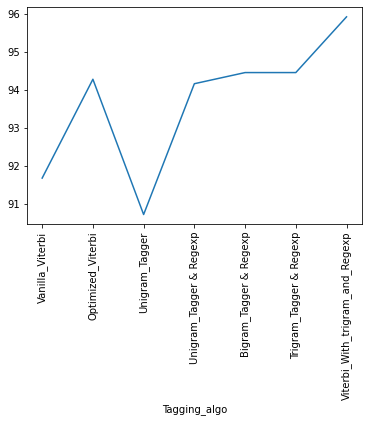

In [53]:
accuracydf.set_index('Tagging_algo', drop=True , inplace = True)
accuracydf.plot.line(rot=90 , legend=False)
plt.show()

`As we can see the accuracy improved from Vanilla Viterbi algorithm (91.6) to Viterbi with trigram regex tagger (95.9)`

### Lets check the accuracy on the test sentences provided in sample file`

In [54]:
# test sentences
sample_test_sentences = ['Android is a mobile operating system developed by Google.',
'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
'Google and Twitter made a deal in 2015 that gave Google access to Twitter''s firehose.',
'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
'Show me the cheapest round trips from Dallas to Atlanta',
'I would like to see flights from Denver to Philadelphia.',
'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
'NASA invited social media users to experience the launch of ICESAT-2 Satellite.']

In [59]:
#tokenizing  and tagging the words with universal tagset
sample_test_tokens = [ word_tokenize(sent) for sent in sample_test_sentences]
sample_test_pos_tags=  nltk.pos_tag_sents(sample_test_tokens ,tagset='universal')
sample_test_pos_tags[:5]

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitters', 'NOUN'),
  ('firehose', 'ADV'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'),
  ('social', '

In [60]:
# sample tagged words and test run base
sample_test_taggedwords= [tup[0] for sent in sample_test_pos_tags for tup in sent]
sample_test_runbase= [tup for sent in sample_test_pos_tags for tup in sent]
sample_test_taggedwords[:10]

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.']

### Case 1 :- Testing the sample cases with Vanilla Viterbi Algorithm

In [61]:
start = time.time()
sampleTest_taggedseq_vanilla_viterbi = Viterbi(sample_test_taggedwords)
end = time.time()
time_diff= end-start
print("Time taken in seconds: ", time_diff)
# Vanilla Viterbi accuracy
check = [i for i, j in zip(sampleTest_taggedseq_vanilla_viterbi, sample_test_runbase) if i == j] 
Vanilla_Viterbi_accuracy_sampletest = len(check)/len(sampleTest_taggedseq_vanilla_viterbi)
Vanilla_Viterbi_accuracy_sampletest

Time taken in seconds:  29.618754148483276


0.7666666666666667

### Case 2 :- Testing the sample cases with Viterbi for Unknown words Algorithm

In [62]:
start = time.time()
sampleTest_taggedseq_unknownwords_viterbi = Viterbi_unknownwords_m1(sample_test_taggedwords)
end = time.time()
time_diff= end-start
print("Time taken in seconds: ", time_diff)
# Optimized  Viterbi accuracy for sample cases
unknownwords_Viterbi_check = [i for i, j in zip(sampleTest_taggedseq_unknownwords_viterbi, sample_test_runbase) if i == j] 
unknownwords_Viterbi_accuracy_sampletest = len(unknownwords_Viterbi_check)/len(sampleTest_taggedseq_unknownwords_viterbi)
unknownwords_Viterbi_accuracy_sampletest

Time taken in seconds:  29.22203826904297


0.8611111111111112

### Case 3 :- Testing the sample cases with  Viterbi backed by trigram and regex Algorithm

In [63]:
start = time.time()
sampleTest_taggedseq_trigram_viterbi = Viterbi_backedbytrigram(sample_test_taggedwords)
end = time.time()
time_diff= end-start
print("Time taken in seconds: ", time_diff)
# Optimized  Viterbi accuracy for sample cases
trigram_Viterbi_check = [i for i, j in zip(sampleTest_taggedseq_trigram_viterbi, sample_test_runbase) if i == j] 
trigram_Viterbi_accuracy_sampletest = len(trigram_Viterbi_check)/len(sampleTest_taggedseq_trigram_viterbi)
trigram_Viterbi_accuracy_sampletest

Time taken in seconds:  116.57483220100403


0.9222222222222223

In [64]:
# Accuracy on test data sets
accuracy_data_testsample = [['Vanilla_Viterbi' ,Vanilla_Viterbi_accuracy_sampletest *100] , 
                 ['Unknownwords_Viterbi' ,unknownwords_Viterbi_accuracy_sampletest*100] ,
                 ['trigram_Viterbi_accuracy_sampletest' ,trigram_Viterbi_accuracy_sampletest*100] 
                
                ]
accuracydf_testsample = pd.DataFrame(accuracy_data_testsample , columns=['Tagging_algo','Accuracy_Score'])
accuracydf_testsample

,Tagging_algo,Accuracy_Score
0,Vanilla_Viterbi,76.666667
1,Unknownwords_Viterbi,86.111111
2,trigram_Viterbi_accuracy_sampletest,92.222222


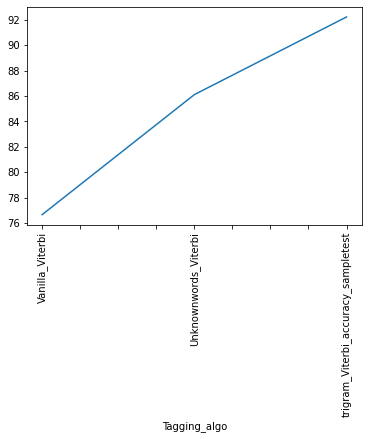

In [65]:
accuracydf_testsample.set_index('Tagging_algo', drop=True , inplace = True)
accuracydf_testsample.plot.line(rot=90 , legend=False)
plt.show()

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [66]:
cols = ['actual_tags' , 'tagged_by_vanilla_viterbi' , 'tagged_by_unknown_words' , 'tagged_by_trigramTagger']
comparison_tags_df = pd.DataFrame(columns=cols)
comparison_tags_df= comparison_tags_df.fillna(0)
comparison_tags_df.actual_tags = [tup for tup in sample_test_runbase]
comparison_tags_df.tagged_by_vanilla_viterbi =[tup for tup in sampleTest_taggedseq_vanilla_viterbi ]
comparison_tags_df.tagged_by_unknown_words= [tup for tup in sampleTest_taggedseq_unknownwords_viterbi ]
comparison_tags_df.tagged_by_trigramTagger= [tup for tup in sampleTest_taggedseq_trigram_viterbi ]
# checking the tags incorrectly tagged by vanilla viterbi and correctly by trigram tagger
comparison_tags_df[comparison_tags_df.tagged_by_vanilla_viterbi!=comparison_tags_df.tagged_by_trigramTagger]

,actual_tags,tagged_by_vanilla_viterbi,tagged_by_unknown_words,tagged_by_trigramTagger
0,"(Android, NOUN)","(Android, ADJ)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, ADJ)","(Google, DET)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, ADJ)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, ADJ)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, ADJ)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, ADJ)","(smartphones, DET)","(smartphones, VERB)"
20,"(2011, NUM)","(2011, ADJ)","(2011, DET)","(2011, NUM)"
25,"(2013, NUM)","(2013, ADJ)","(2013, DET)","(2013, NUM)"
27,"(Google, NOUN)","(Google, ADJ)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, ADJ)","(Twitter, NOUN)","(Twitter, NOUN)"


## Conclusion 
Thus we see that most of the words that were incorrectly tagged by the vanilla viterbi algorithm were corrected by the viterbi algorithm backed up by the trigram tagger.

- Method 1 :- If a word isnt present in training set then its emission probability will be zero and hence state prob. will inturn be zero.Thus in cases we can omit the emission probabaility for unknown words and keep only transition probability.
  
  - We got 94.27 % accuracy on validation set
  - 86% accuracy  on sample test cases

- Method 2: Viterbi Trigram backed by bigram, unigram & rule based tagger 
    - 95.9 % accuracy  on validation set
    - 92.2 % accuracy on sample test case
